# Sequential x amortized inference

In this notebook, we will analyse the performance of Simulation-based inference algorithms in estimating the posterior distribution of the parameters defined in the Two Moons model.

## The Two Moons model

The parameters $\boldsymbol{\theta} \in \mathbb{R}^2$ are sampled from

$$ \theta_1 \sim \mathcal{U}([-1, 1])$$
$$ \theta_2 \sim \mathcal{U}([-1, 1])$$

The data $\boldsymbol{x} \in \mathbb{R}^2$ are generated as follows:

1. Sample the latent variables $$\alpha \sim \mathcal{U}([-\pi/2, \pi/2])$$ $$r \sim \mathcal{N}(\mu=0.1, \sigma=0.01)$$
2. Define $$p = (r \cos \alpha + 0.25, r \sin \alpha)$$
3. Output $$\boldsymbol{x} = p - \left(\frac{|\theta_1 + \theta_2|}{\sqrt{2}}, \frac{\theta_1 - \theta_2}{\sqrt{2}} \right)$$

The name of the model comes from the shape of the posterior distribution $p(\boldsymbol{\theta} | \boldsymbol{x})$: bimodal with a banana-shaped mass around the modes (a-la a crescent moon).


In [29]:
import sys

sys.path.append("..")

import torch
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import arviz as az
from sbi import analysis as analysis
from sbi import utils as utils

from sbisandbox.examples import TwoMoonsToyModel
from sbisandbox.benchmark import SNPEBenchmark, SNREBenchmark, MCMCBenchmark

%matplotlib
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-whitegrid")

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [30]:
two_moons = TwoMoonsToyModel()
seed = 1998

The `TwoMoonsToyModel` class has built-in methods for the prior and the simulator $\bm{x} | \bm{\theta}$ of the two moons model. Let us generate observations of $(\boldsymbol{\theta}, \boldsymbol{x})$ and visualize them as 2D histograms:

In [31]:
# Check prior, return PyTorch prior.
num_observations = 1000
theta, x = two_moons.get_observations(
    num_observations=num_observations, seed=seed, simulation_batch_size=None
)

/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_16271/2237418342.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


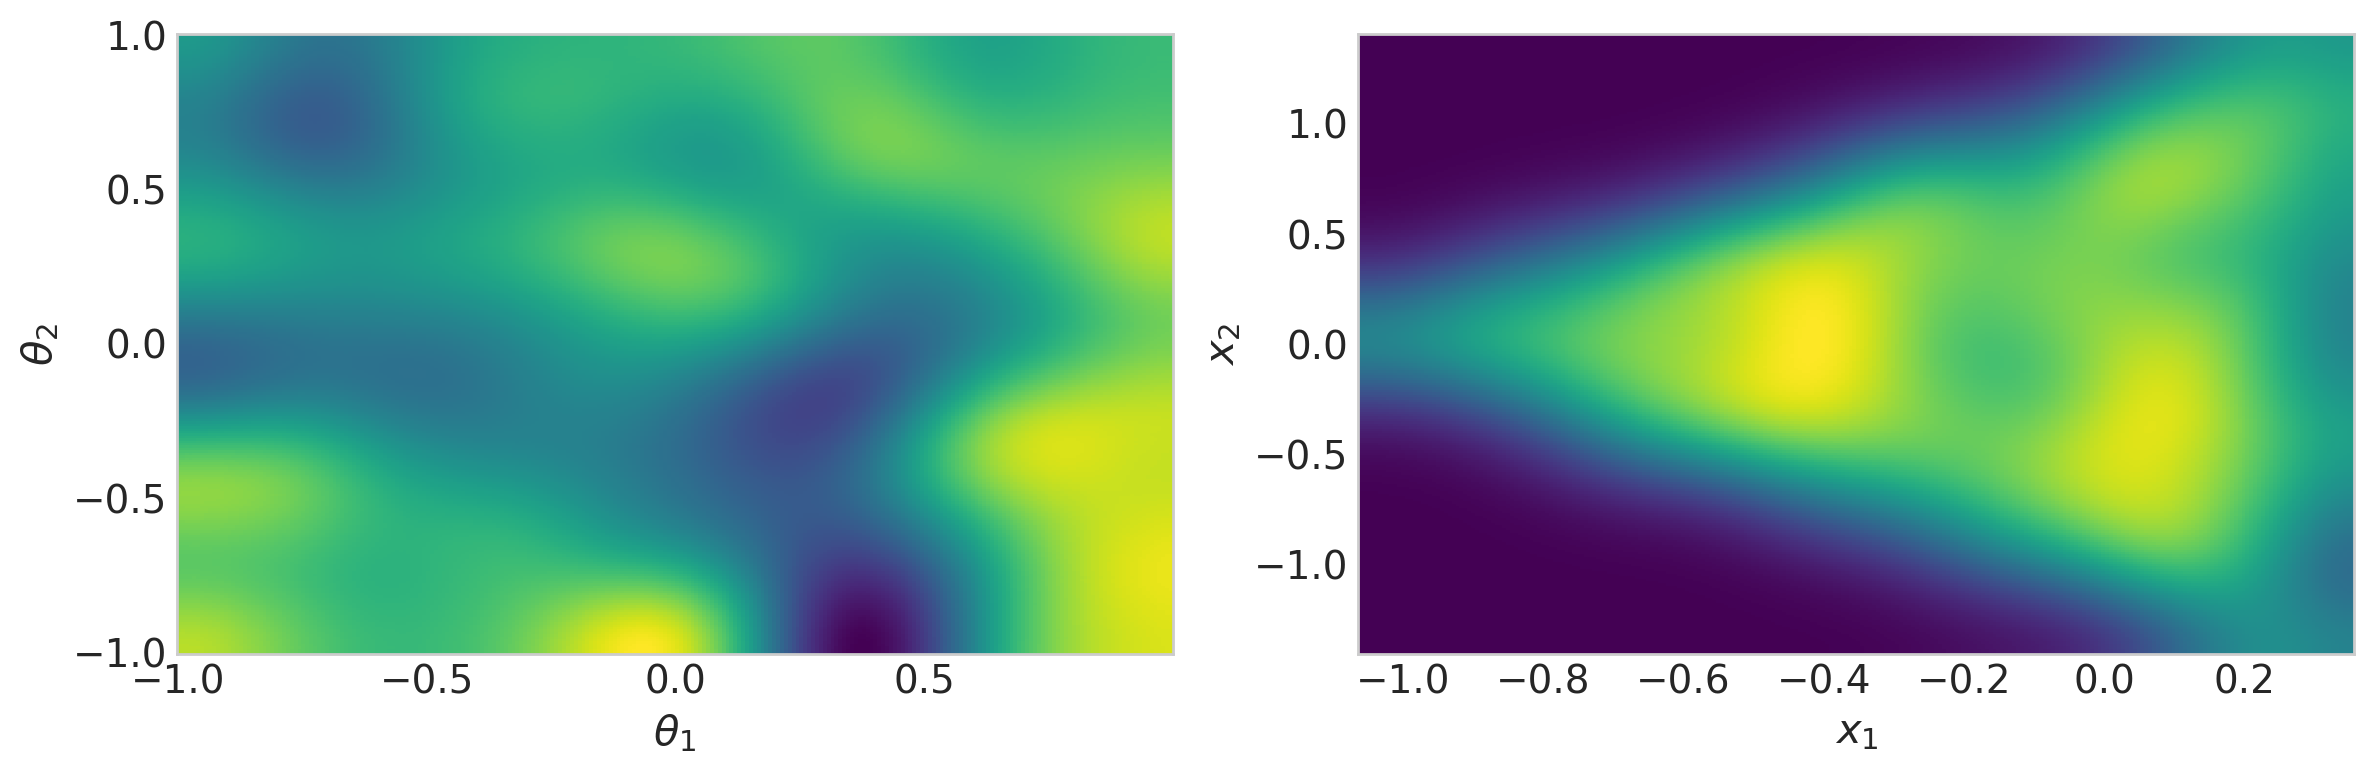

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
theta = theta.detach().numpy()
x = x.detach().numpy()
az.plot_kde(theta[:, 0], theta[:, 1], contour=False, ax=ax1)
az.plot_dist(x[:, 0], x[:, 1], contour=False, ax=ax2)
ax1.set(xlabel="$\\theta_1$", ylabel="$\\theta_2$")
ax2.set(xlabel="$x_1$", ylabel="$x_2$")
fig.tight_layout()
plt.show()

We observe that the distribution for $\boldsymbol{x}$ has this rather triangular shape. We can have a quantitative understanding of this behaviour by calculating the likelihood function explicitly (or the posterior, rather, since the prior $p(\boldsymbol{\theta})$ is a constant.

\begin{align*}
p(\boldsymbol{\theta} | \boldsymbol{x}) &= p(\boldsymbol{x} | \boldsymbol{\theta}) p(\boldsymbol{\theta})\\
&= p(\boldsymbol{\theta}) \int p(\boldsymbol{x}, r, \alpha | \boldsymbol{\theta})  dr \, d\alpha\\
&= p(\boldsymbol{\theta})\int p(\boldsymbol{x} | r, \alpha, \boldsymbol{\theta}) p(r, \alpha | \boldsymbol{\theta}) dr \, d\alpha\\
&= p(\boldsymbol{\theta})\int \delta(\boldsymbol{x} - \boldsymbol{x}(r, \alpha, \boldsymbol{\theta})) p(r) p(\alpha) dr \, d\alpha\\
\end{align*}

The delta function over $\mathbb{R}^2$ will fix both values of $r$ and $\alpha$ to the solution of

$$ \boldsymbol{x}(r, \alpha, \boldsymbol{\theta}) = \boldsymbol{x},$$

where $\boldsymbol{\theta}$ and $\boldsymbol{x}$ are given, and $\boldsymbol{x}(r, \alpha, \boldsymbol{\theta})$ indicates the functional form of $\boldsymbol{x}$ as a function of the other variables. Hence, we find the posterior to be

\begin{equation*}
 p(\boldsymbol{\theta} | \boldsymbol{x})= \begin{cases}
 \frac{1}{4} \frac{1}{\pi} \frac{1}{\sqrt{2 \pi} 0.01} \exp \left\{ -\frac{1}{2} \left( \frac{r(\boldsymbol{\theta}, \boldsymbol{x}) - 0.1}{0.01} \right)^2 \right\}, & \text{if } |\theta_1 + \theta_2| \geq \sqrt{2} (0.25 - x_1),\\
0, & \text{if } |\theta_1 + \theta_2| < \sqrt{2} (0.25 - x_1),
\end{cases}
\end{equation*}

where

$$ r(\boldsymbol{\theta}, \boldsymbol{x}) = \text{sgn} \left(|\theta_1 + \theta_2| - \sqrt{2} (0.25 - x_1) \right) \sqrt{\left(x_1  - 0.25 + \frac{|\theta_1 + \theta_2|}{\sqrt{2}}\right)^2 + \left(x_2 + \frac{\theta_1 - \theta_2}{\sqrt{2}}\right)^2}$$

The region $|\theta_1 + \theta_2| < \sqrt{2} (0.25 - x_1)$ corresponds to a solution with $\cos \alpha < 0$, which is not possible for $\alpha \in (-\pi/2, \pi/2)$, thereby reducing the posterior support on $\boldsymbol{\theta}$.

We now consider the observation $\boldsymbol{x}_0 = (0, 0)$, and plot the posterior $p(\boldsymbol{\theta} | \boldsymbol{x}_0)$ below.

In [33]:
def r_of_theta_x(theta1, theta2, x):
    x1, x2 = x
    plus = np.abs(theta1 + theta2) / np.sqrt(2)
    minus = (theta1 - theta2) / np.sqrt(2)
    rsin = x2 + minus
    rcos = x1 - 0.25 + plus
    sign_r = np.where(rcos >= 0, 1, -1)
    return sign_r * np.sqrt(rsin**2 + rcos**2)


def p_theta_given_x(theta1, theta2, x):
    x1, x2 = x
    plus = np.abs(theta1 + theta2) / np.sqrt(2)
    minus = (theta1 - theta2) / np.sqrt(2)
    rsin = x2 + minus
    rcos = x1 - 0.25 + plus
    sign_r = np.where(rcos >= 0, 1, -1)
    r = sign_r * np.sqrt(rsin**2 + rcos**2)
    chi = (r - 0.1) / 0.01
    norm = 1.0 / (4 * np.pi * np.sqrt(2 * np.pi) * 0.01)
    prob = norm * np.exp(-0.5 * chi**2)
    prob[rcos * sign_r < 0] = 0.0
    return prob

/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_16271/2220580468.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


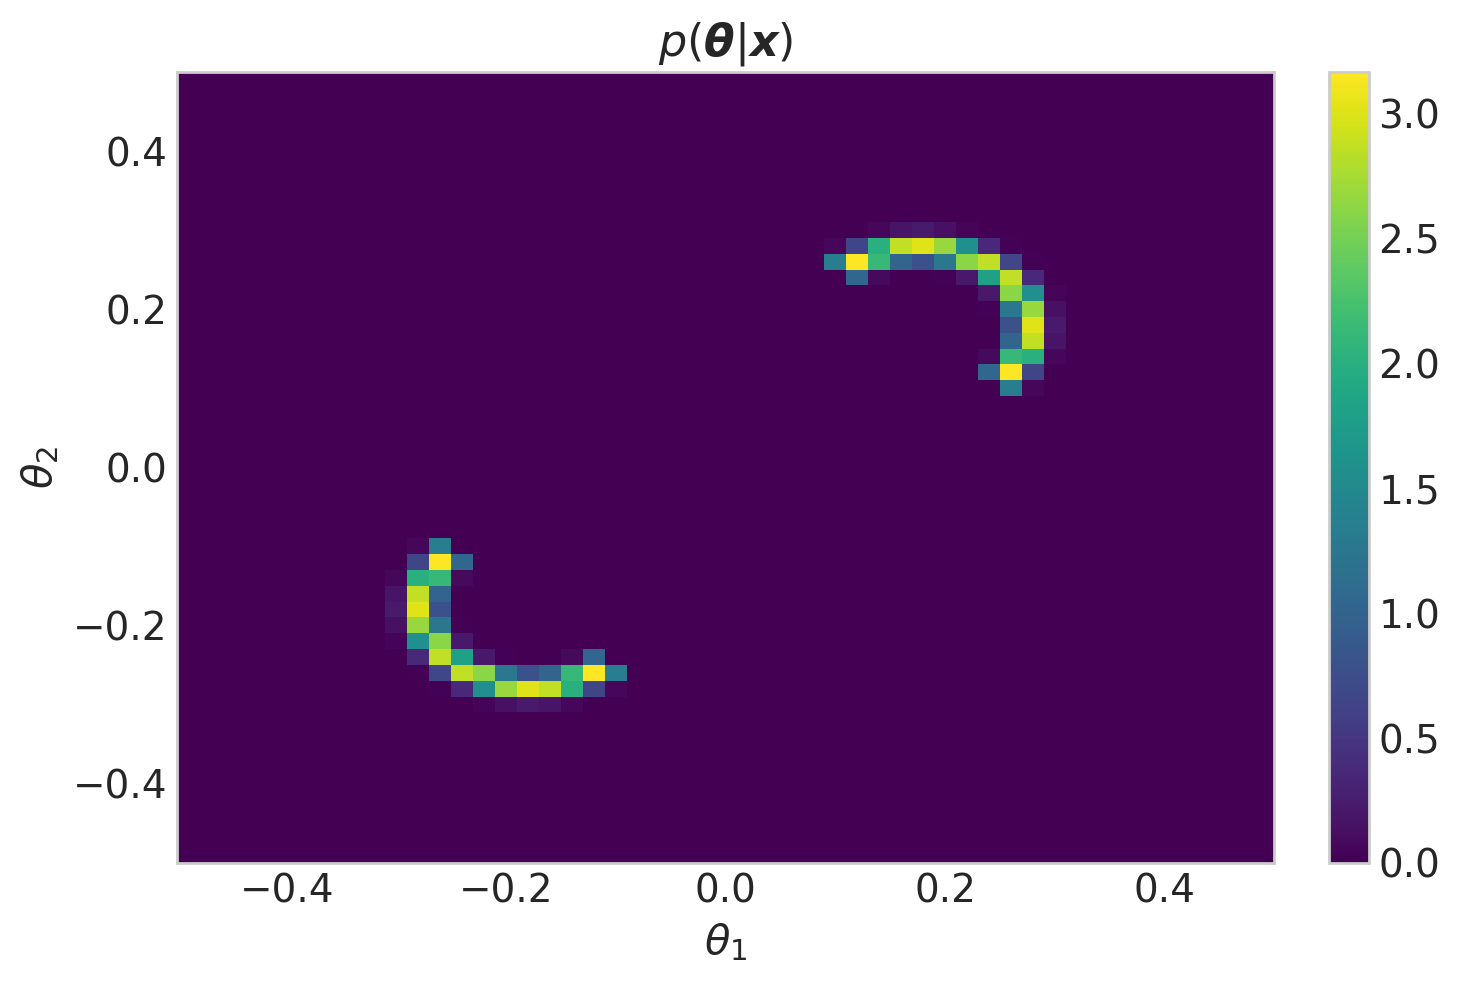

In [34]:
N = 100
theta1 = np.linspace(-1, 1, N + 1)
theta2 = np.linspace(-1, 1, N + 1)
x0 = np.zeros(2)

fig, ax = plt.subplots()
tt1, tt2 = np.meshgrid(theta1, theta2)
r = r_of_theta_x(tt1, tt2, x0)
a = 0.25
ax.scatter([-a, a], [-a, a], color="w")
im = ax.pcolormesh(tt1, tt2, p_theta_given_x(tt1, tt2, x0), antialiased=True)
fig.colorbar(im, ax=ax)

ax_kwargs = {
    "xlabel": "$\\theta_1$",
    "ylabel": "$\\theta_2$",
    "xlim": [-0.5, 0.5],
    "ylim": [-0.5, 0.5],
    "title": "$p(\\boldsymbol{\\theta} | \\boldsymbol{x})$",
}

ax.set(**ax_kwargs)
# fig.tight_layout()
fig.show()

The posterior is found to concentrate most of its mass in two disjoint, banana-shaped regions. The density resembles two crescent moons facing each other, hence the name of the model.

From the figure, it is clear that the effective support of the posterior is much smaller relative to the prior support $[0,1]^2$. Besides, from the fact that the two moons are separated by a (much larger) region of low posterior mass, we expect the performance of an MCMC to be very sensitive to the initialization strategy of the chains and the step size of the method.

To gather reference samples from the posterior, we implement below a simple Metropolis-Hastings algorithm with the independent proposal distribution

$$ \boldsymbol{\theta}' | \boldsymbol{\theta} \sim 0.5\mathcal{N}(p_1, \sigma) + 0.5\mathcal{N}(p_2, \sigma),$$

Where $p_1 = (0.25 / \sqrt{2}, 0.25 / \sqrt{2})$ and $p_2 = (-0.25 / \sqrt{2}, -0.25 / \sqrt{2})$ approximate the curvature center of the moons, and $\sigma$ is fixed.


In [35]:
from torch.distributions import MultivariateNormal


def within_support(theta):
    return np.abs(np.sum(theta, axis=-1)) > np.sqrt(2) * 0.25


def sample_from_proposal(num_samples: int, num_chains: int, sigma: float):
    p = 0.25  # / np.sqrt(2)
    p1 = p * torch.ones(2)
    p2 = -p * torch.ones(2)
    cov = sigma * torch.eye(2)
    dist_high = MultivariateNormal(p1, cov)
    dist_low = MultivariateNormal(p2, cov)
    u = torch.rand((num_samples, num_chains)).unsqueeze(-1)
    high_samples = dist_high.sample((num_samples, num_chains))
    low_samples = dist_low.sample((num_samples, num_chains))
    return torch.where(u > 0.5, high_samples, low_samples).numpy()


def logp_theta_of_x0(theta):
    r = r_of_theta_x(theta[..., 0], theta[..., 1], np.zeros(2))
    return -0.5 * (r - 0.1) ** 2 / 0.01**2


def naive_hastings(
    num_samples: int, theta0: ArrayLike, num_chains: int = 1, sigma: float = 0.1
):
    logu = np.log(np.random.rand(num_samples, num_chains))
    chains = np.empty((num_samples, num_chains, 2))
    chains[0, ...] = theta0
    proposal_samples = sample_from_proposal(num_samples, num_chains, sigma)
    logp_samples = logp_theta_of_x0(proposal_samples)
    chains_within_support = within_support(proposal_samples)
    current_logp = logp_theta_of_x0(theta0)
    for i in range(1, num_samples):
        old = chains[i - 1, ...]
        target = proposal_samples[i, ...]
        log_alpha = logp_samples[i, :] - current_logp
        condition = chains_within_support[i, :] & (log_alpha > logu[i, :])
        current_logp = np.where(condition, logp_samples[i, :], current_logp)
        chains[i, :] = np.where(condition[:, None], target, old)

    return chains.swapaxes(0, 1)  # Swap (sample, chain) by (chain, sample)

In [36]:
num_samples = 100000
num_chains = 5
sigma = 0.3
theta0 = sample_from_proposal(1, num_chains, sigma).squeeze()
samples = naive_hastings(num_samples, theta0, num_chains, sigma)

Our implementation takes very few seconds to generate the samples. Let us plot some diagnostics for the chains:

array([<Axes: title={'center': '$\\theta_1$'}, xlabel='Quantile', ylabel='Relative ESS for quantiles'>,
       <Axes: title={'center': '$\\theta_2$'}, xlabel='Quantile', ylabel='Relative ESS for quantiles'>],
      dtype=object)

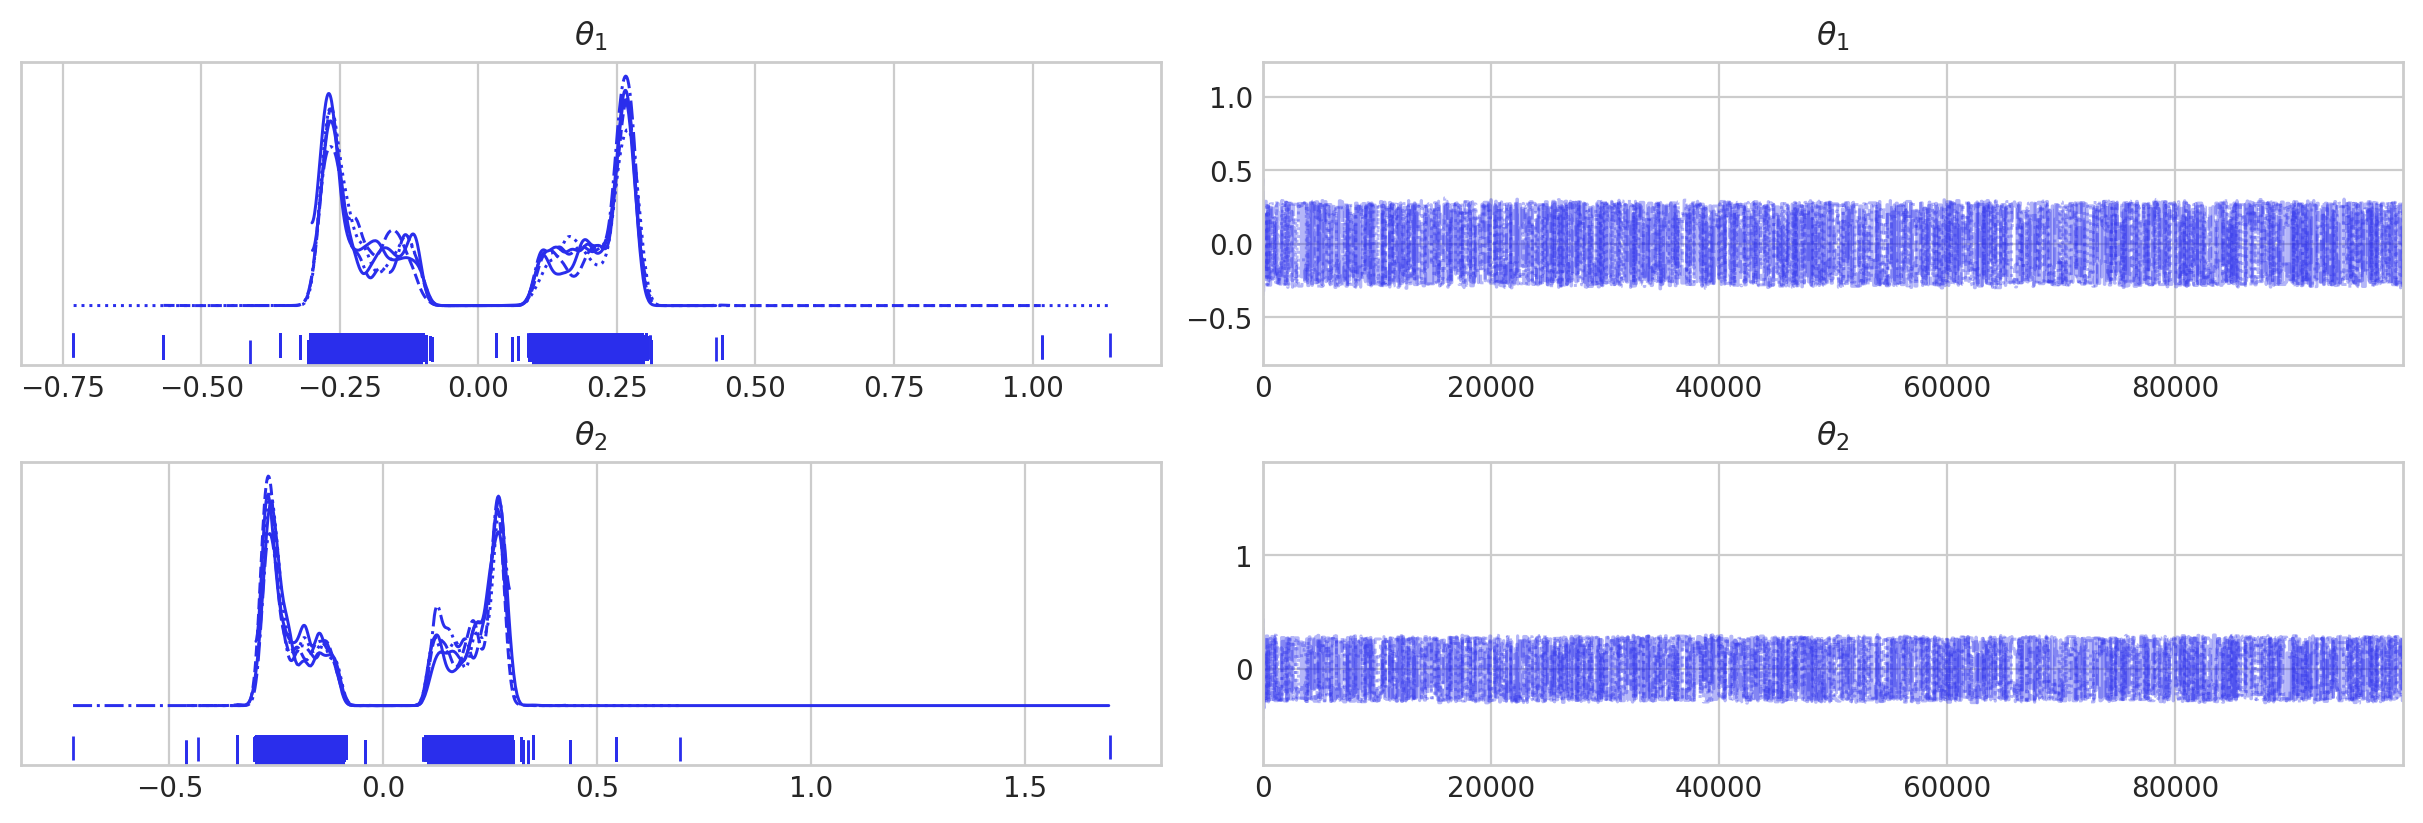

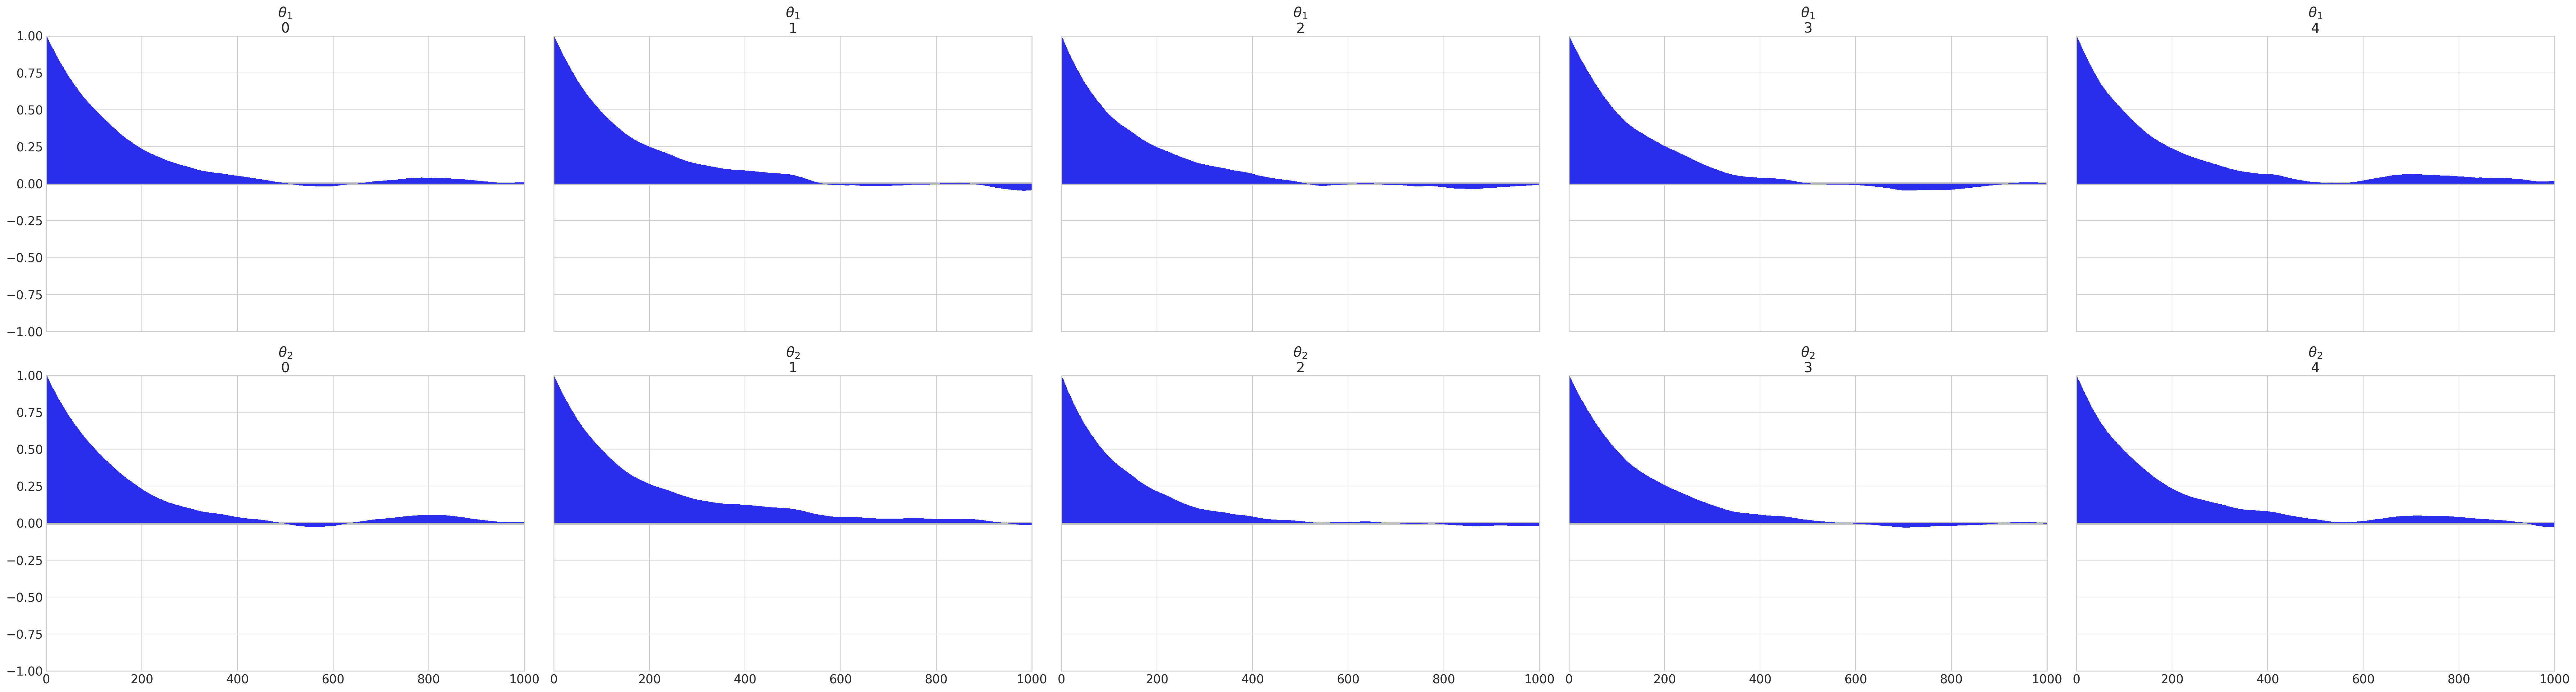

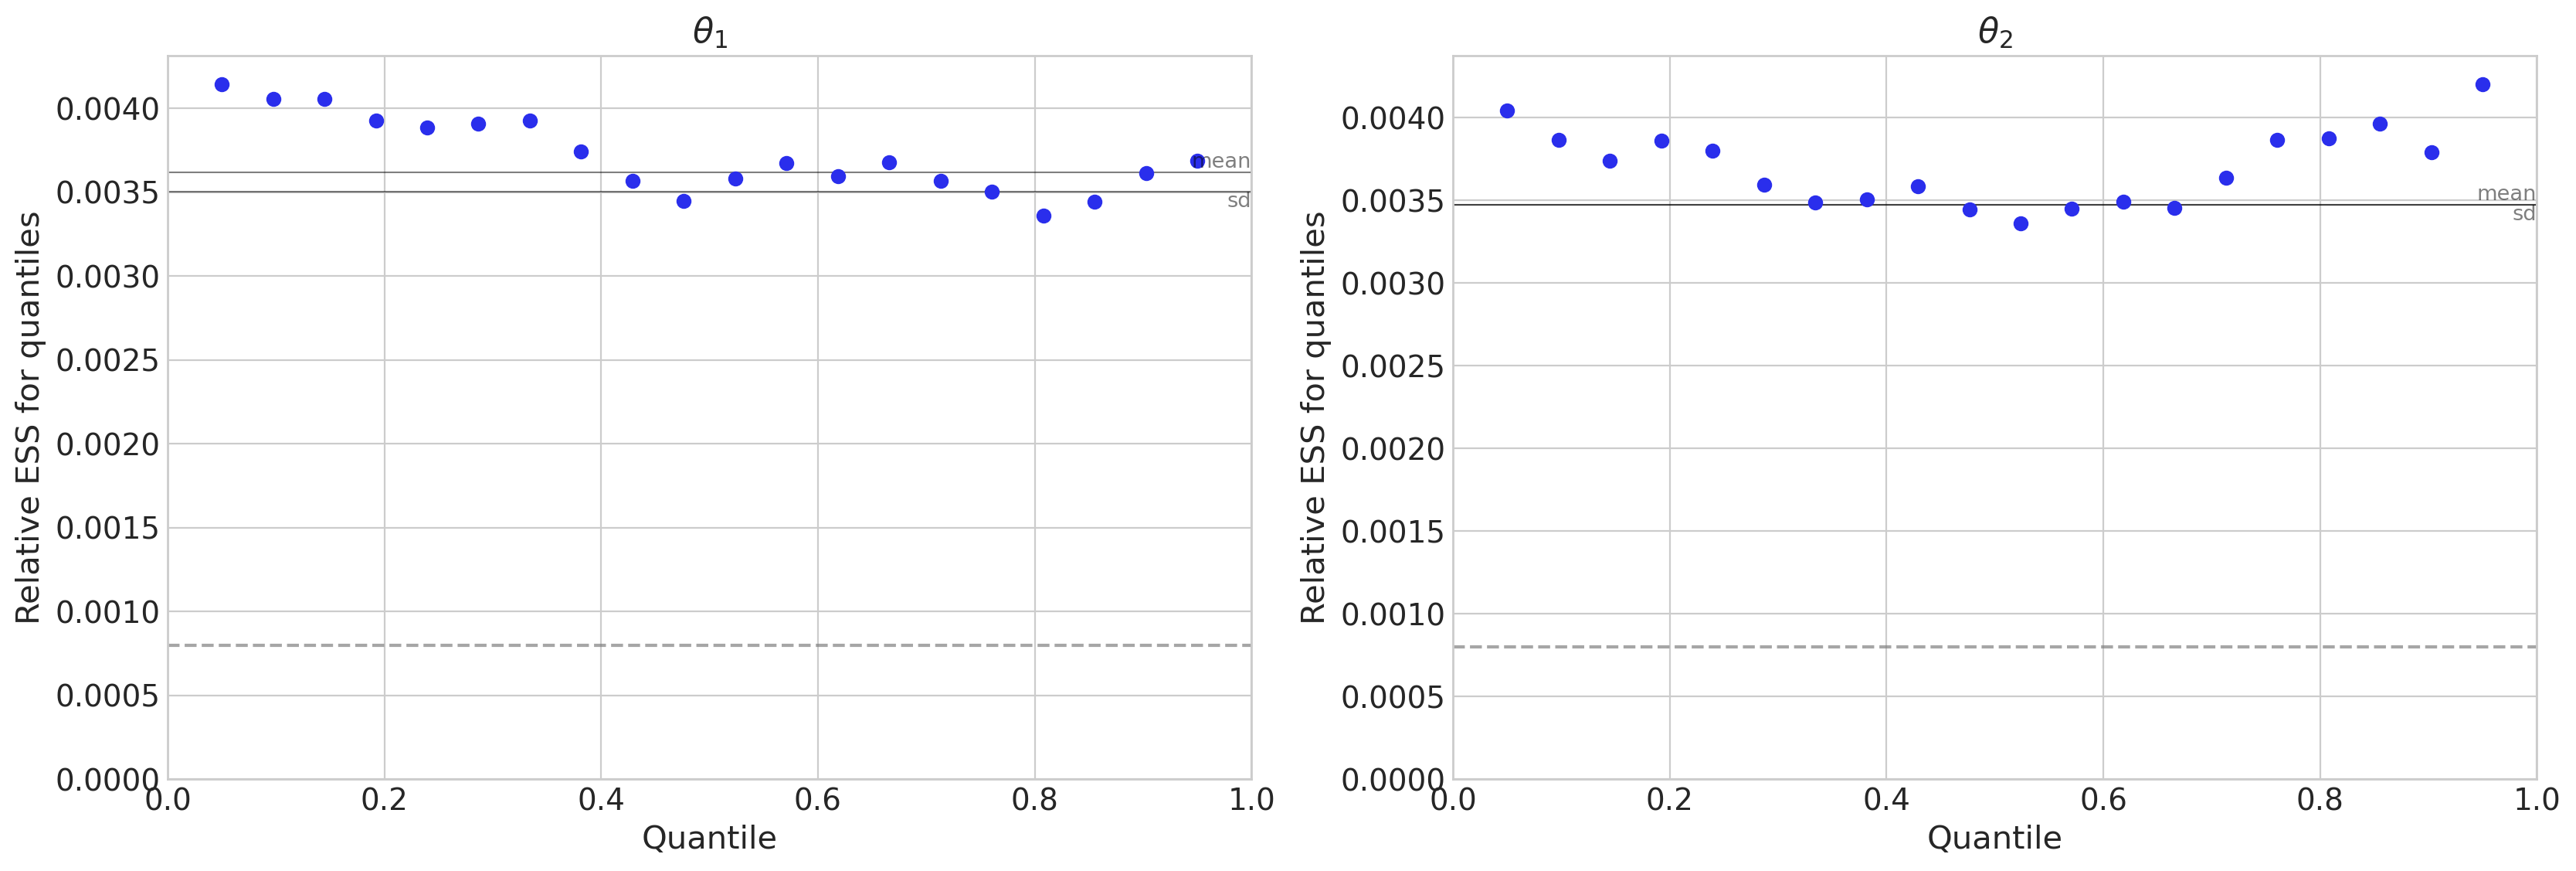

In [37]:
labels = ["$\\theta_1$", "$\\theta_2$"]


def get_data(samples, warmup: int = None, thin: int = 1):
    data = (samples[:, warmup::thin, 0], samples[:, warmup::thin, 1])
    return dict(zip(labels, data))


data = get_data(samples)
az.plot_trace(data, var_names=labels, rug=True)
az.plot_autocorr(data, var_names=labels, grid=(2, 5), max_lag=1000)
az.plot_ess(data, var_names=labels, relative=True, kind="quantile", extra_methods=True)

The uniform autocorrelation across the chains comes from the rejection of samples from the independent proposal, since the overlap between the moons and the gaussian support is limited.


Finally, we visualize our samples in a corner plot:

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

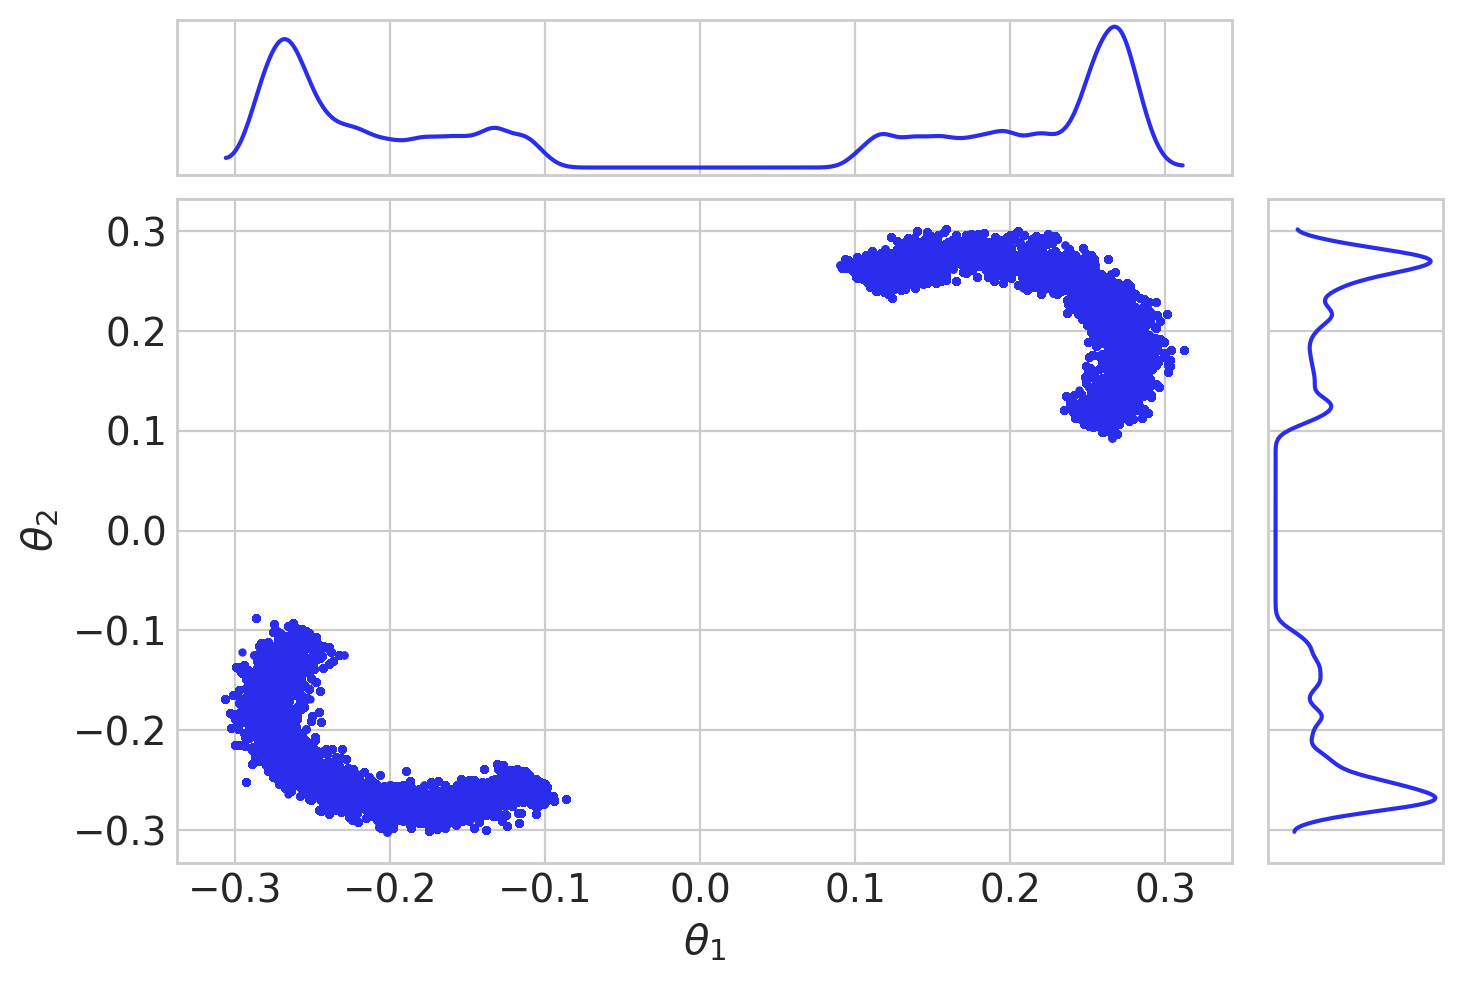

In [38]:
data = get_data(samples, warmup=400)
az.plot_pair(data, var_names=labels, marginals=True)

We will use `SNPE`, `SNLE`, and `SRE` in this benchmark.

In [39]:
snpe = SNPEBenchmark(toy_model=two_moons, seed=seed)
snre = SNREBenchmark(toy_model=two_moons, seed=seed)

Training the neural networks sequentially:

In [40]:
# from sbi.inference import SNPE, simulate_for_sbi
num_simulations = 10000
training_kwargs = {"show_train_summary": True}
# snpe = SNPE(prior=two_moons.prior)
# theta, x = simulate_for_sbi(two_moons.simulator, two_moons.prior, num_simulations, simulation_batch_size=None, seed=seed)
# snpe.append_simulations(theta, x).train()
snpe.train(num_simulations, training_kwargs=training_kwargs)
print(f"Training time: {snpe.training_time:.1f} s")

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 75 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 75
        Best validation performance: 3.5251
        -------------------------
        
Training time: 1432.4 s


In [41]:
# def plot(algorithm, samples):
#      # plot posterior samples
#     fig, axs = analysis.pairplot(
#         samples,
#         limits=[[-0.5, 0.5], [-0.5, 0.5]],
#         labels=["$\\theta_1$", "$\\theta_2$"],
#         figsize=(5, 5),
#     )
#     fig.suptitle(algorithm)
#     plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

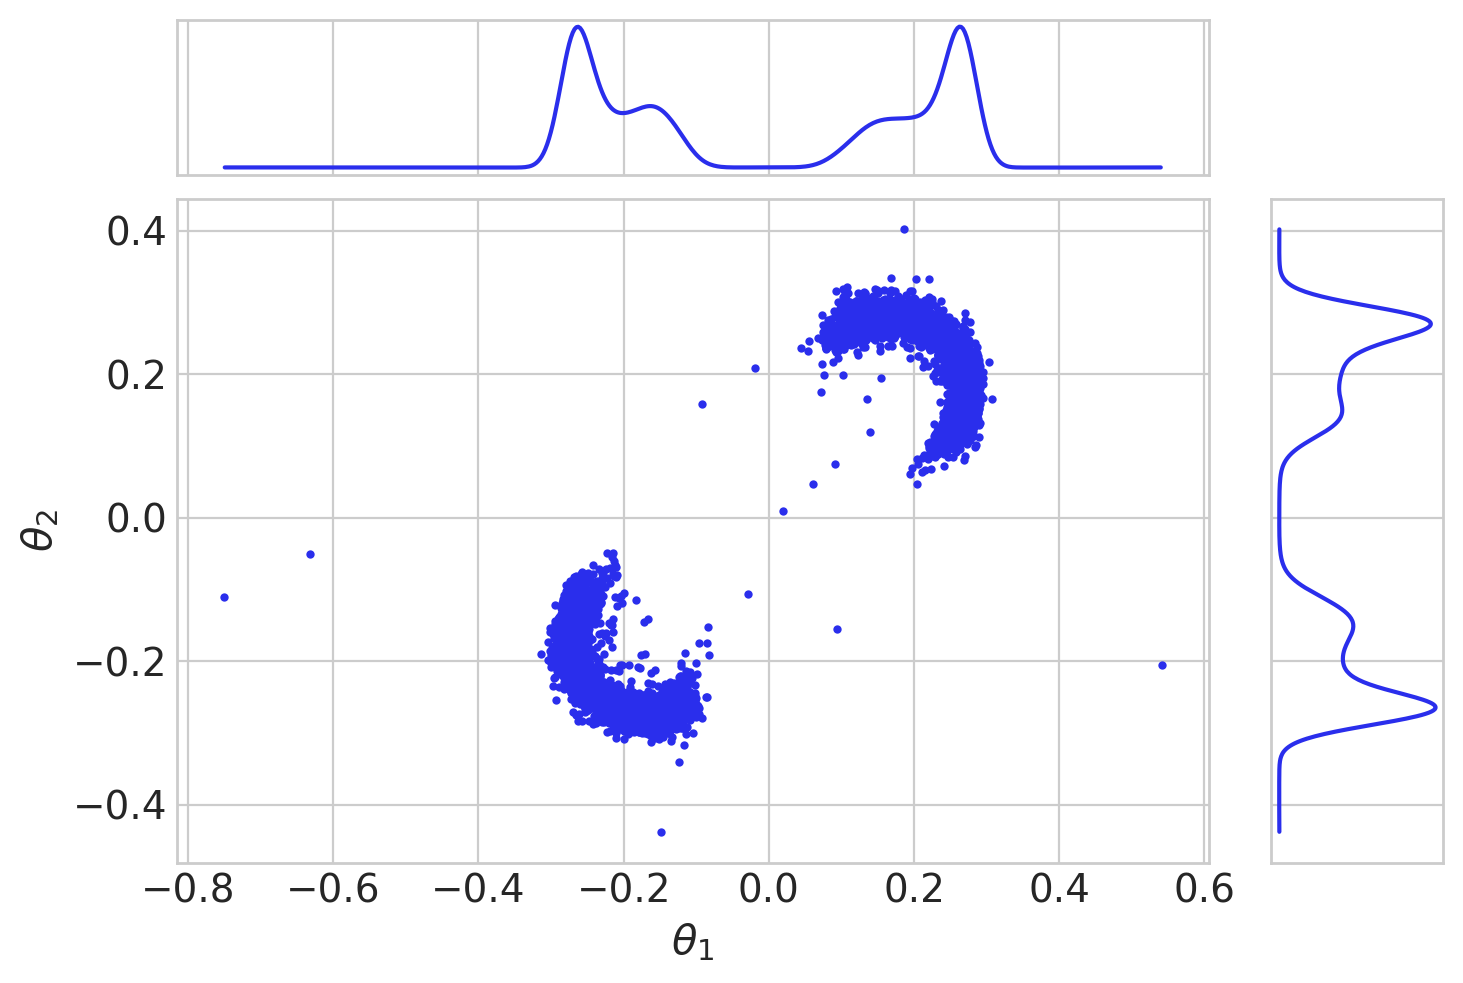

In [42]:
num_samples = 10000
x0 = torch.tensor([0, 0])
samples = snpe.sample(num_samples, x=x0)
# print(snpe.sampling_time)
data = dict(zip(labels, (samples[:, 0], samples[:, 1])))
az.plot_pair(data, var_names=labels, marginals=True)

The results seem to be...not good. Let us try the sequential version, SNPE:

In [43]:
snpe.reset()
snpe.train(num_simulations, num_rounds=3, x_0=x0, training_kwargs=training_kwargs)

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

 Neural network successfully converged after 58 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 58
        Best validation performance: 3.2387
        -------------------------
        


Drawing 3333 posterior samples:   0%|          | 0/3333 [00:00<?, ?it/s]

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 66
        Best validation performance: -0.3272
        -------------------------
        


Drawing 3333 posterior samples:   0%|          | 0/3333 [00:00<?, ?it/s]

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -0.4774
        -------------------------
        


(DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
 NFlowsFlow(
   (net): Flow(
     (_transform): CompositeTransform(
       (_transforms): ModuleList(
         (0): AffineTransform()
         (1): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): ResidualNet(
             (initial_layer): Linear(in_features=3, out_features=50, bias=True)
             (blocks): ModuleList(
               (0-1): 2 x ResidualBlock(
                 (context_layer): Linear(in_features=2, out_features=50, bias=True)
                 (linear_layers): ModuleList(
                   (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
                 )
                 (dropout): Dropout(p=0.0, inplace=False)
               )
             )
             (final_layer): Linear(in_features=50, out_features=29, bias=True)
           )
         )
         (2): LULinear()
         (3): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): Residu

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

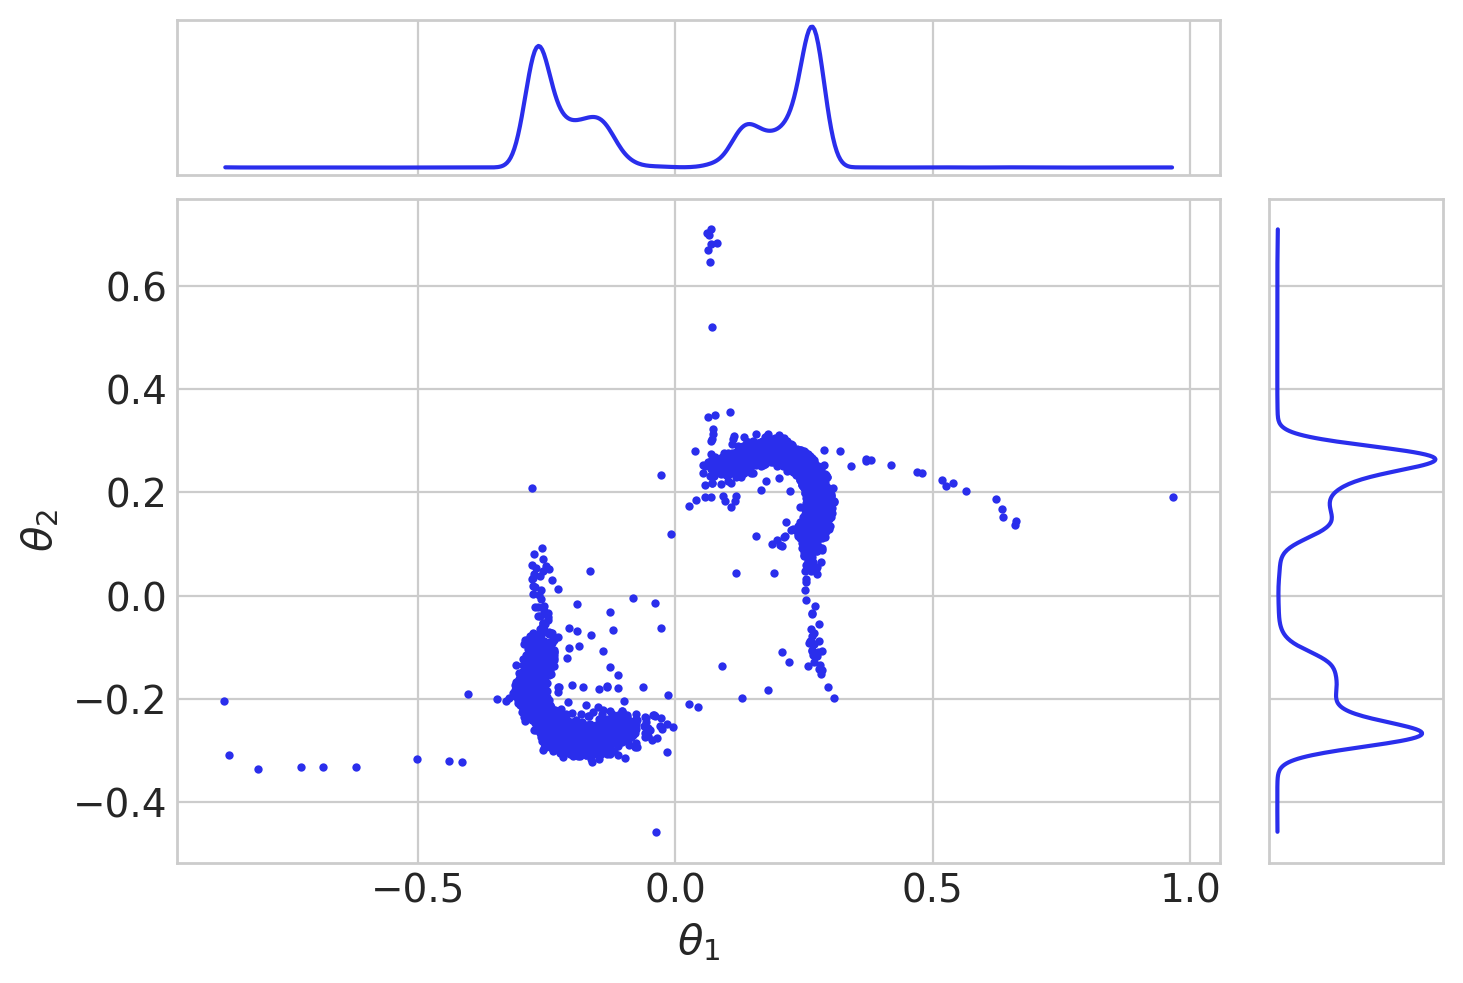

In [44]:
num_samples = 10000
samples = snpe.sample(num_samples, x=torch.tensor([0, 0]))
# print(snpe.sampling_time)
data = dict(zip(labels, (samples[:, 0], samples[:, 1])))
az.plot_pair(data, var_names=labels, marginals=True)

## Sequential NRE

In [45]:
snre.train(num_simulations)
print(f"Training time: {snre.training_time:.1f} s")

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 84 epochs.Training time: 188.3 s


/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10200 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

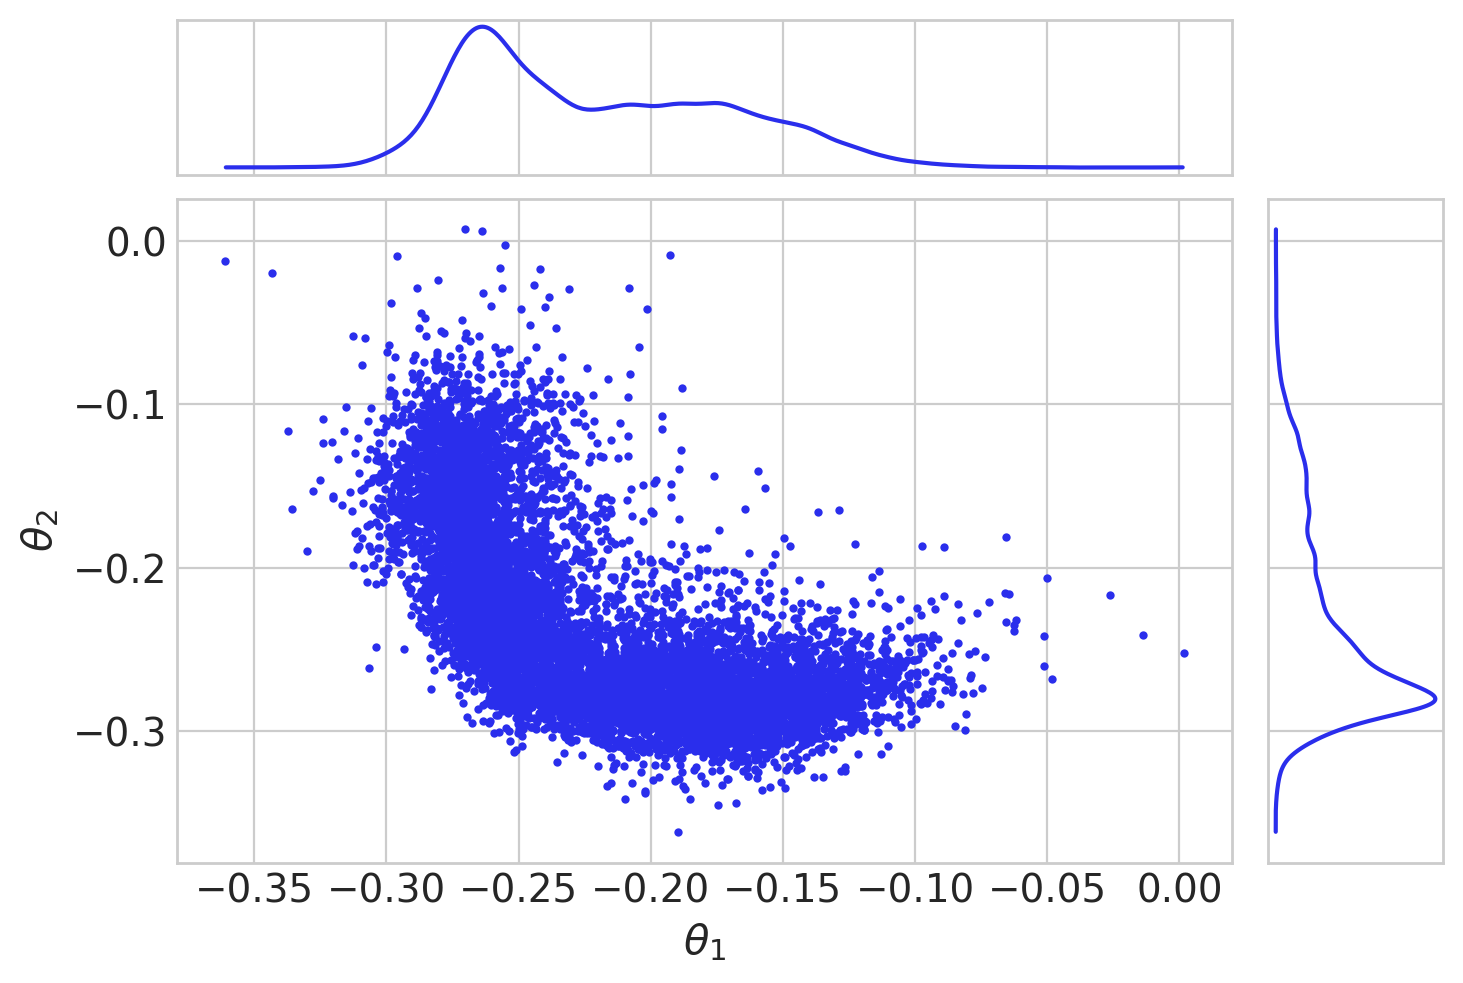

In [46]:
num_samples = 10000
samples = snre.sample(num_samples, x=torch.tensor([0, 0]))
# print(snpe.sampling_time)
# plot('SNRE', samples)
data = dict(zip(labels, (samples[:, 0], samples[:, 1])))
az.plot_pair(data, var_names=labels, marginals=True)

In [47]:
snre.reset()
snre.train(num_simulations, num_rounds=3, x_0=x0, training_kwargs=training_kwargs)
print(f"Training time: {snre.training_time:.1f} s")

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -0.0021
        -------------------------
        


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3533 [00:00<?, ?it/s]

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

 Neural network successfully converged after 79 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 79
        Best validation performance: -0.0056
        -------------------------
        


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3533 [00:00<?, ?it/s]

Running 3333 simulations.:   0%|          | 0/3333 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -0.0099
        -------------------------
        
Training time: 475.7 s


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10200 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

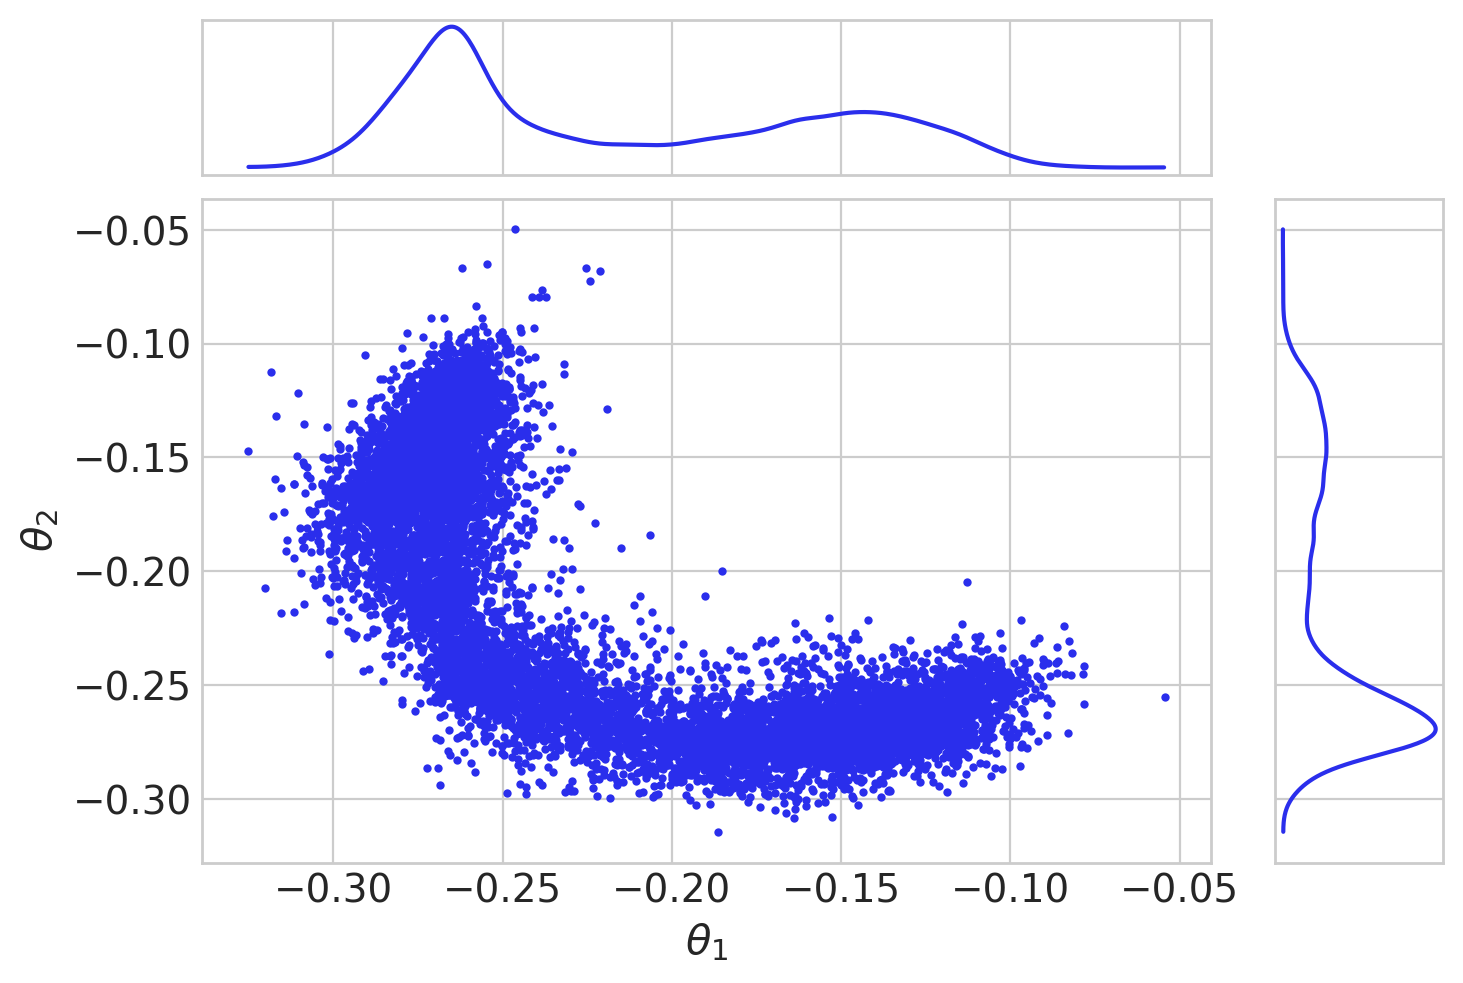

In [48]:
num_samples = 10000
samples = snre.sample(num_samples, x=torch.tensor([0, 0]))
# print(snpe.sampling_time)
# plot('SNRE', samples)
data = dict(zip(labels, (samples[:, 0], samples[:, 1])))
az.plot_pair(data, var_names=labels, marginals=True)

In [49]:
mcmc = MCMCBenchmark(two_moons, seed=seed)
samples = mcmc.sample(1000000, x=torch.tensor([0, 0]))
# data = get_data(samples, warmup=400)
# az.plot_pair(data, var_names=labels, marginals=True)

Sample: 100%|████████████████████████████████| 2000000/2000000 [03:24, 9766.21it/s, step size=1.00e+00, acc. prob=1.000]                                                      


In [50]:
print(samples)

{}


We build the posteriors with rejection sampling for `SNLE` and `SRE`.

In [51]:
# x_0 = torch.zeros(2)
# def plot(algorithm, samples):
#      # plot posterior samples
#     fig, axs = analysis.pairplot(
#         posterior_samples,
#         limits=[[-0.5, 0.5], [-0.5, 0.5]],
#         labels=["$\\theta_1$", "$\\theta_2$"],
#         figsize=(5, 5),
#     )
#     fig.suptitle(algorithm)
#     plt.show()

# print(pipeline._algorithms.keys())

# # SNPE
# posterior = pipeline.SNPE_C.build_posterior()
# posterior_samples = posterior.sample((10000,), x=x_0)
# plot('SNPE_C', posterior_samples)

# # SNRE
# posterior = pipeline.SNLE_A.build_posterior(sample_with='rejection')
# posterior_samples = posterior.sample((10000,), x=x_0)
# plot('SNLE', posterior_samples)

# # SRE
# posterior = pipeline.SNRE_B.build_posterior(sample_with='mcmc', mcmc_method='nuts_pymc')
# posterior_samples = posterior.sample((10000,), x=x_0)
# plot('SRE', posterior_samples)